In [37]:
# Plotting and Data Manipulation
from matplotlib import gridspec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Other
from pdf2image import convert_from_path
from IPython.display import display
import importlib

In [38]:
from pathlib import Path
import sys

parent_dir = str(Path().absolute().parent)
sys.path.append(parent_dir)

print(parent_dir)

/home/wksnr/Public/riset/BWLI-modified


# **1. Data Preparation**

In [39]:
from src.data_prep.read_las import read_las

file_name = "../data/raw/ll-4_wire_lima.las"
well_name = "LL-4"
renamed_columns = {
    "DEPTH": "DEPT",
    "RT": "DR",
    "ILM": "MR",
    "LLS": "SR",
    "NPHI_CORR": "NPHI",
}  # {nama_asli : nama_baru, ... , dst}
columns = [
    "DEPT",
    "GR",
    "CALI",
    "MR",
    "DR",
    "SR",
    "NPHI",
    "RHOB",
    "DT",
    "SP",
    "VSH",
    "RW",
    "WELL",
]

data = read_las(file_name, well_name, renamed_columns, columns, keep_original=False)

Only engine='normal' can read wrapped files


In [40]:
data.describe()

,DEPT,GR,CALI,MR,DR,SR,NPHI,RHOB,DT,SP,VSH,RW
count,13981.000000,10390.000000,10394.000000,10374.000000,10440.000000,1210.000000,9184.000000,9314.000000,9615.000000,10394.000000,4679.000000,13981.000000
mean,3495.000000,63.907625,12.115885,2.312847,3.093636,0.835083,0.420528,2.296849,107.581031,19.632336,0.561747,0.107826
std,2018.055696,27.017865,3.027074,3.298621,8.397807,0.480027,0.097965,0.191633,24.303341,56.193522,0.340048,0.037525
min,0.000000,9.900000,0.000000,0.200600,0.330000,0.174200,0.038000,1.210000,0.000000,-129.000000,0.000000,0.063355
25%,1747.500000,42.062500,9.460000,0.717725,0.802975,0.591600,0.363900,2.182900,89.500000,-37.100000,0.233600,0.076609
50%,3495.000000,64.720000,12.340000,0.932550,1.040000,0.688700,0.431500,2.287200,108.550000,17.950000,0.641300,0.096876
75%,5242.500000,79.400000,12.740000,2.450075,2.852450,0.851100,0.487025,2.420000,122.100000,73.800000,0.868800,0.131724
max,6990.000000,176.800000,22.270000,46.344700,249.379000,2.992300,0.813700,2.770000,191.061000,121.100000,1.000000,0.205728


# **2. Data Distribution Plot**

In [41]:
columns_to_plot = ["GR", "DR", "SR", "NPHI", "RHOB", "VSH", "RW"]
columns_unit = ["API", "ohm/m", "ohm.m", "v/v", "g/cm³", "v/v", "ohm"]

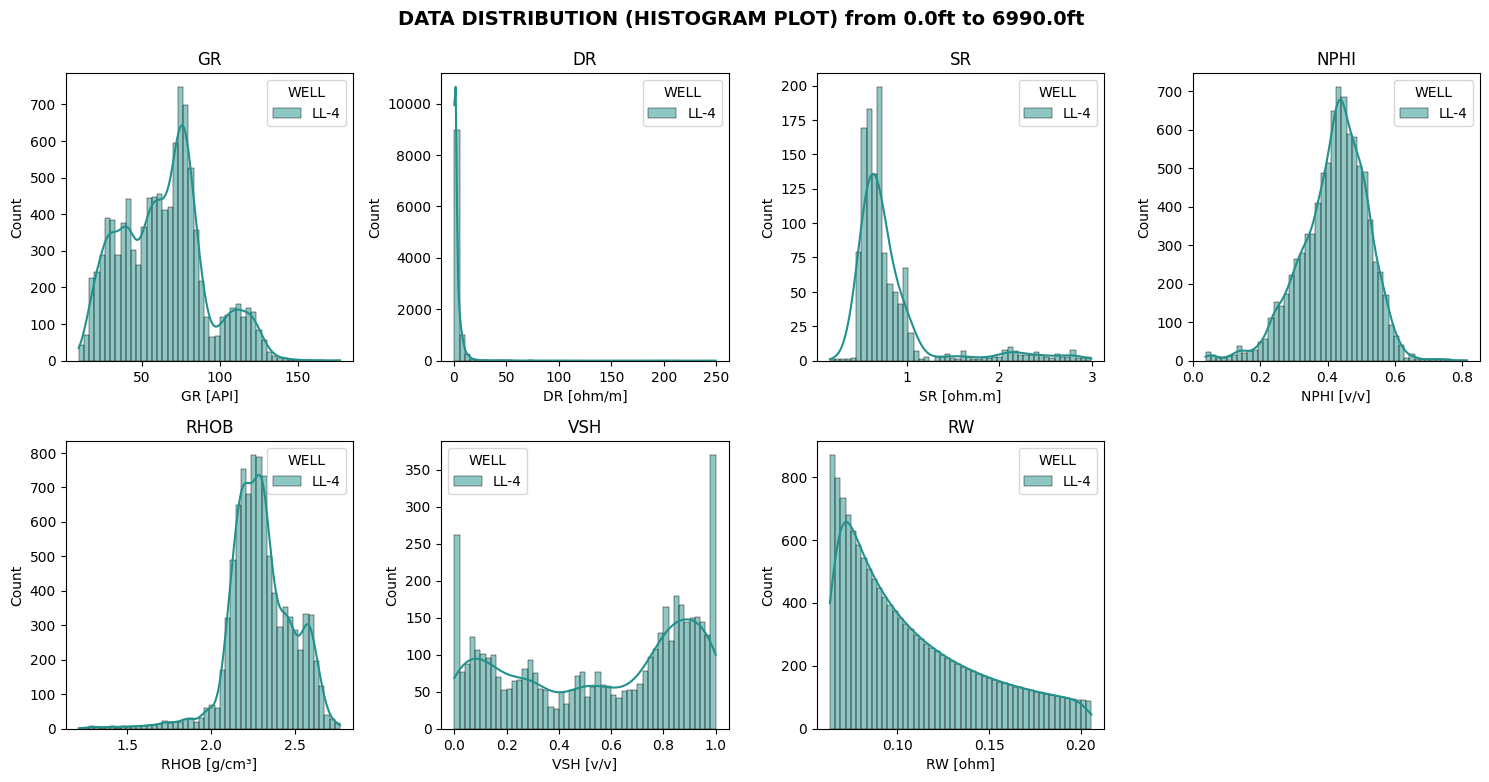

In [42]:
from src.data_vis.distPlot import boxplot, histplot, densityplot

histplot(
    data,
    columns_to_plot,
    columns_unit,
    depth_start=data.DEPT.min(),
    depth_end=data.DEPT.max(),
    axes=(4, 4),
    fig_size=(15, 15),
)

# *3 Data Visualizations*

In [43]:
# Data Corrections
data["NPHI_corr"] = data["NPHI"] - 0.04

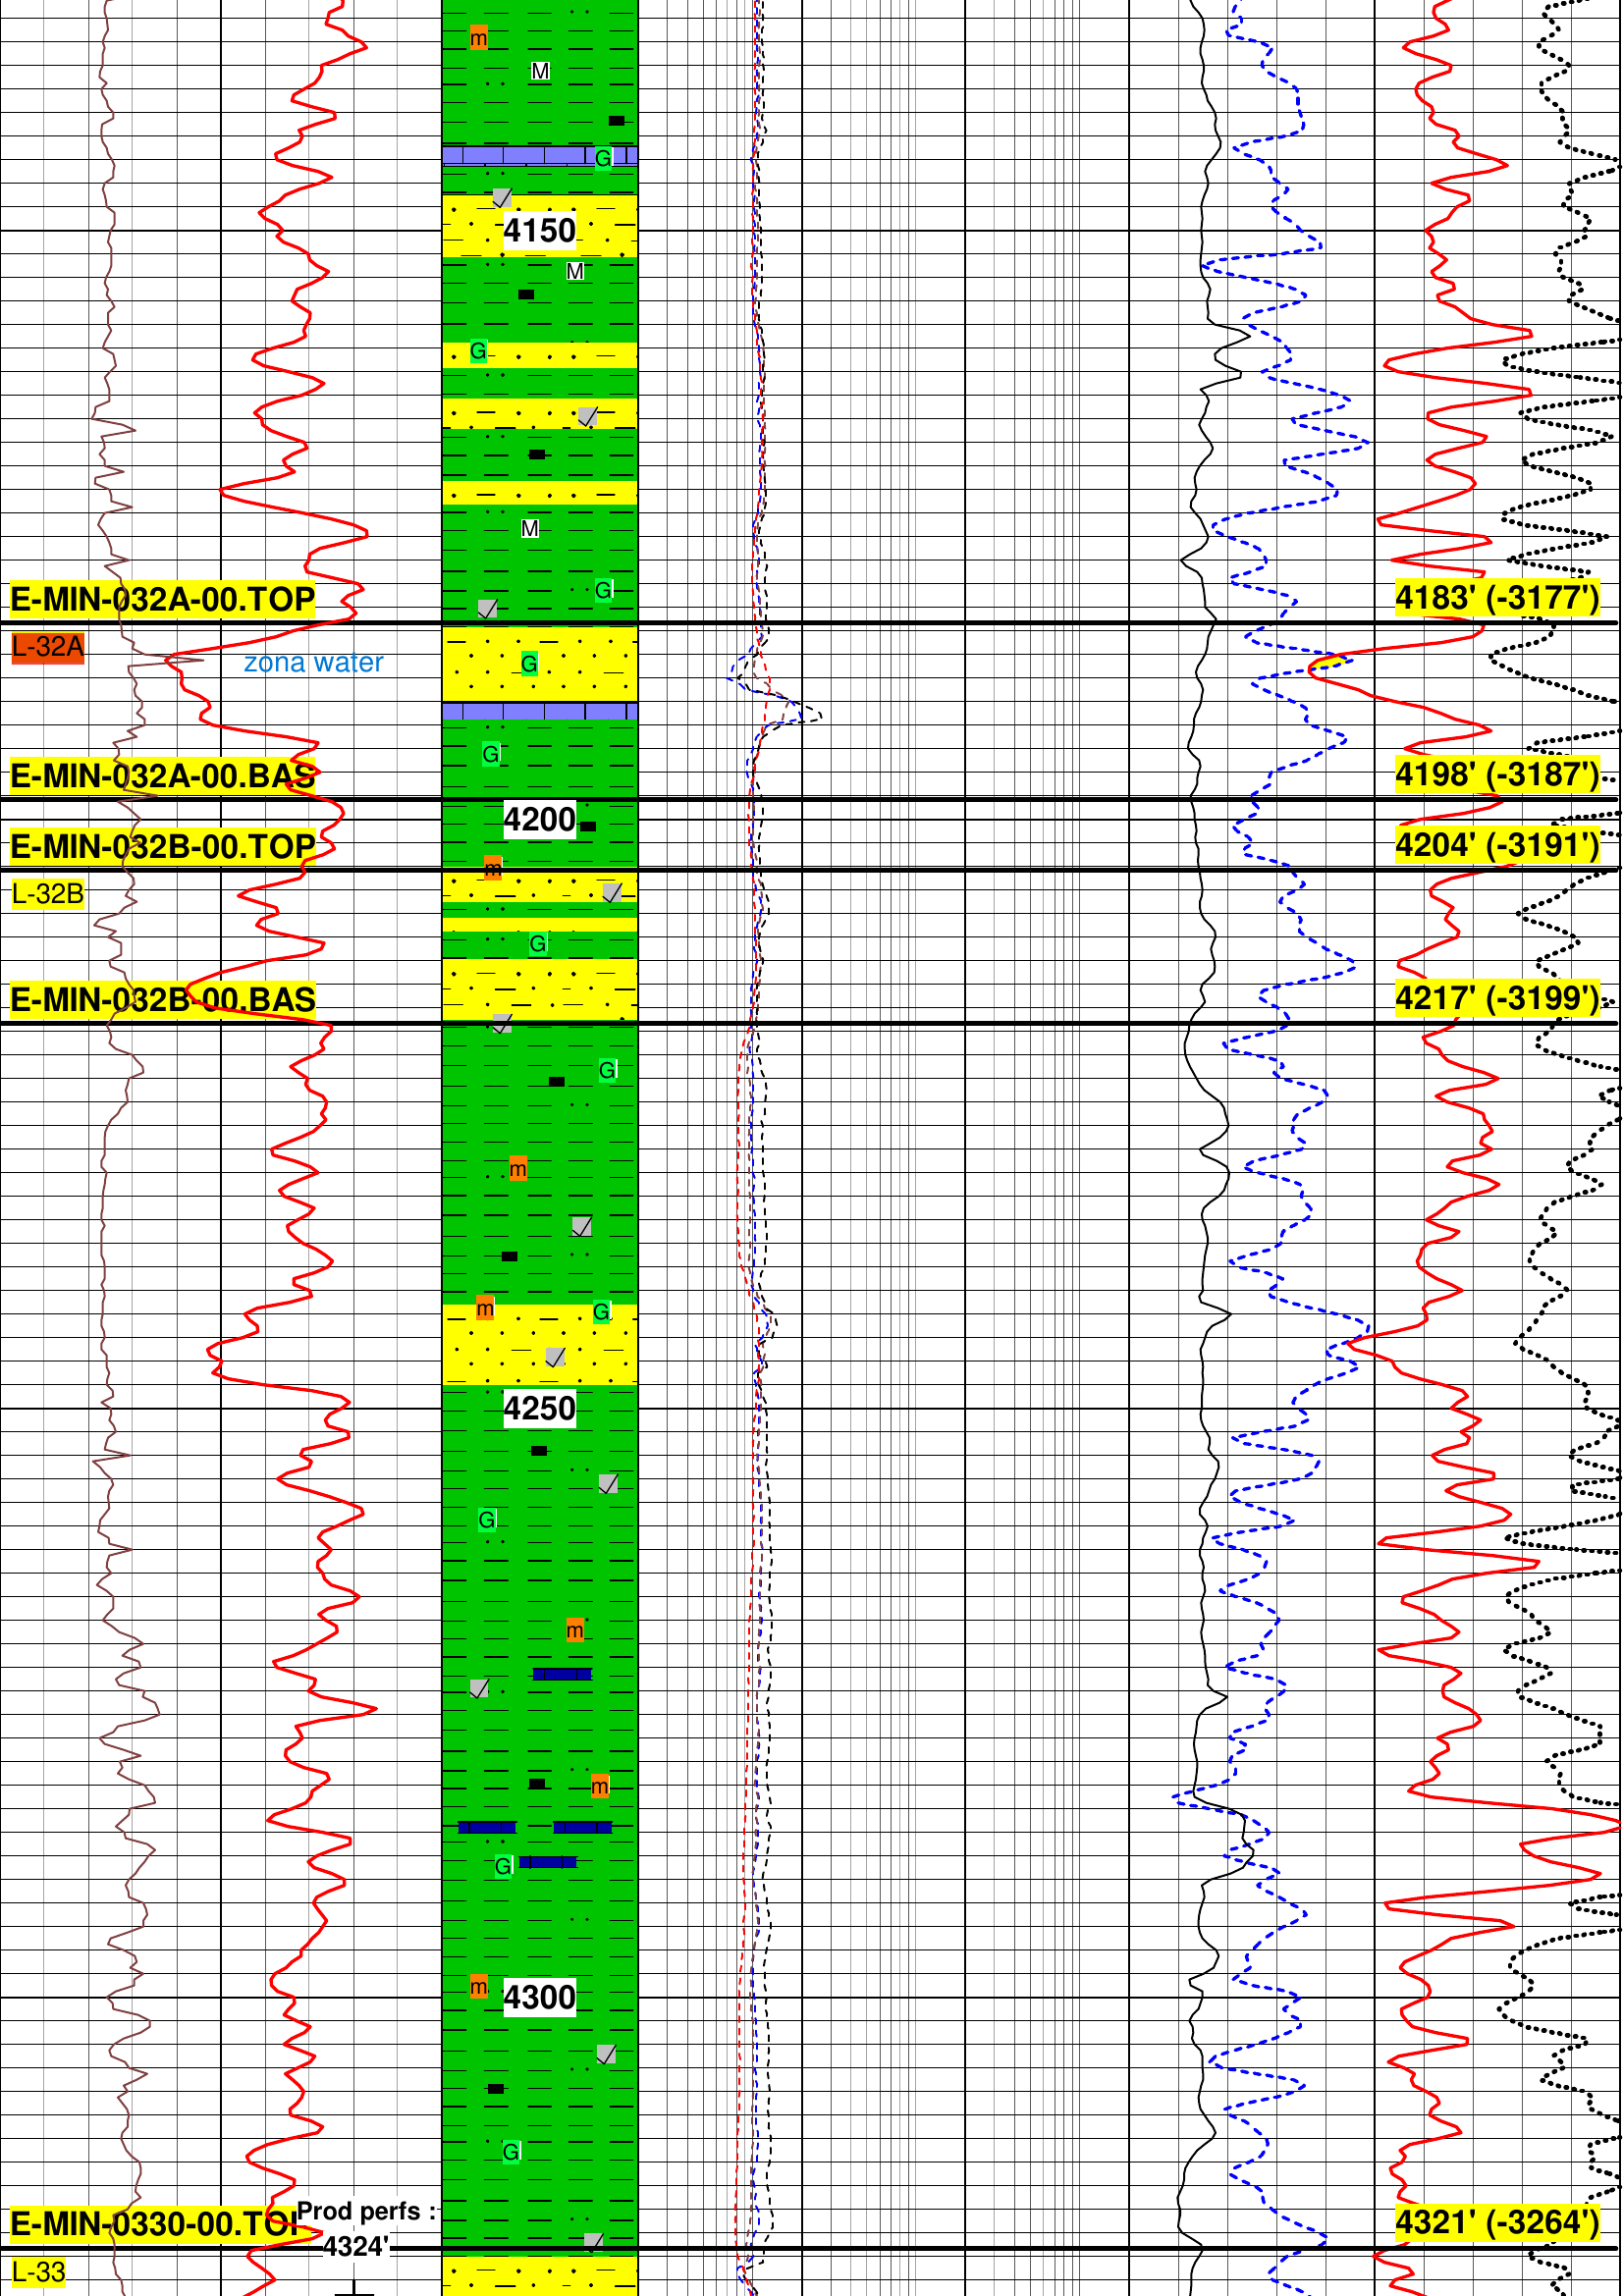

In [44]:
# display completion log
data_completion = convert_from_path(
    "../data/raw/LLB-10 Completion Log.pdf", first_page=20, last_page=20
)
display(data_completion[0])

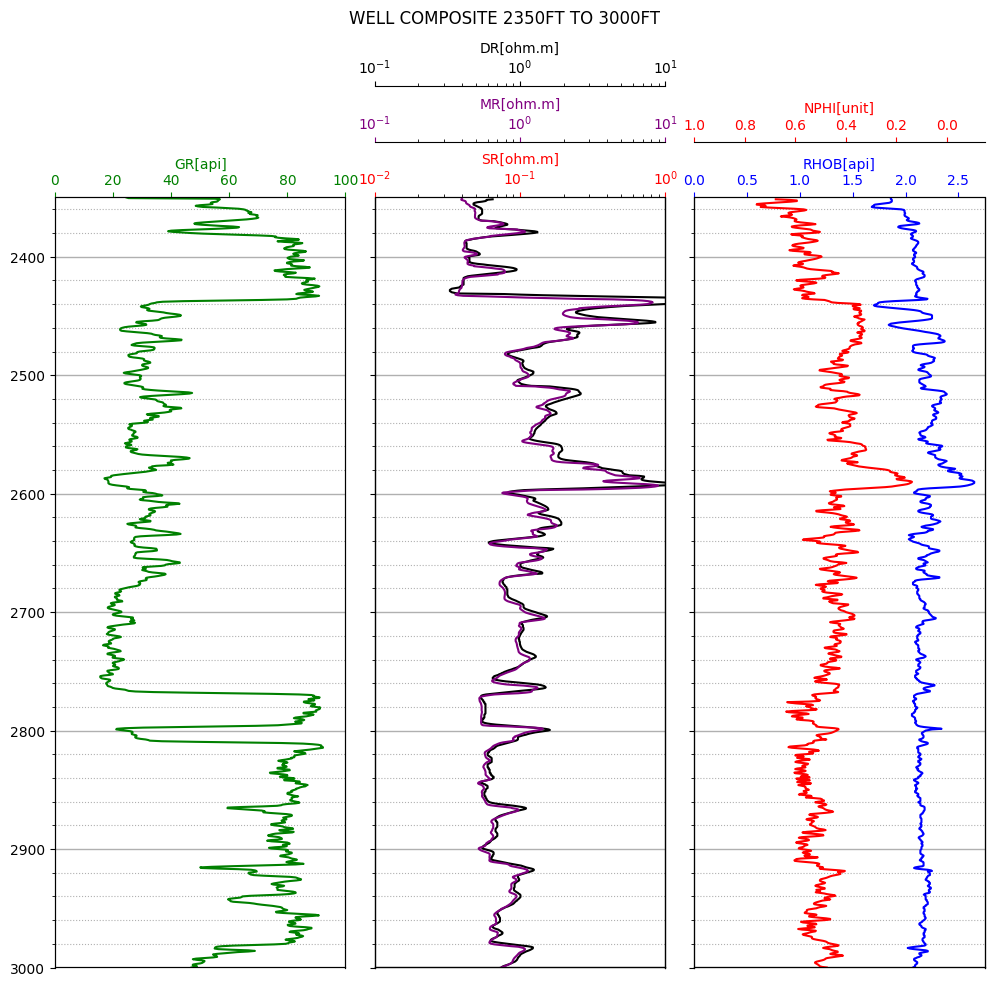

In [45]:
from src.data_vis.comboPlot import combo_plot

# Uncomment the selected_data.DEPT.min()/max() to plot for full depths
depth_start = 2350  # selected_data.DEPT.min()
depth_end = 3000  # selected_data.DEPT.max()
formations = (
    "Torok",
    "Pebble SH",
    "Walakpa SS",
    "J-Klingak",
    "Barrow SS",
    "Klingak SH",
    "T-Sag River SS",
    "Shublik",
    "Basement",
)
formation_depths = (100, 1701, 2071, 2200, 3102, 3224, 3258, 3633)
# DISPLAYS LOG DATA FROM THE END TO THE BOTTOM (MENTAHAN)
combo_plot(
    data,
    depth_start,
    depth_end,
    formations,
    formation_depths,
    figure_height=10,
    suptitleadjust=1.05,
    traject1={
        "data": ["GR"],
        "intervals": [(0, 100)],
        "scales": ["linear"],
        "labels": ["GR[api]"],
        "positions": [0],
        "colors": ["green"],
    },
    traject2={
        "data": ["DR", "MR", "SR"],
        "intervals": [(0.1, 10), (0.1, 10), (0.01, 1)],
        "scales": ["log", "log", "log"],
        "labels": ["DR[ohm.m]", "MR[ohm.m]", "SR[ohm.m]"],
        "positions": [80, 40, 0],
        "colors": ["black", "purple", "red"],
    },
    traject3={
        "data": ["RHOB", "NPHI"],
        "intervals": [(0, 2.75), (1, -0.15)],
        "scales": ["linear", "linear"],
        "labels": ["RHOB[api]", "NPHI[unit]"],
        "positions": [0, 40],
        "colors": ["blue", "red"],
    },
)

ConversionError: Failed to convert value(s) to axis units: 'log'

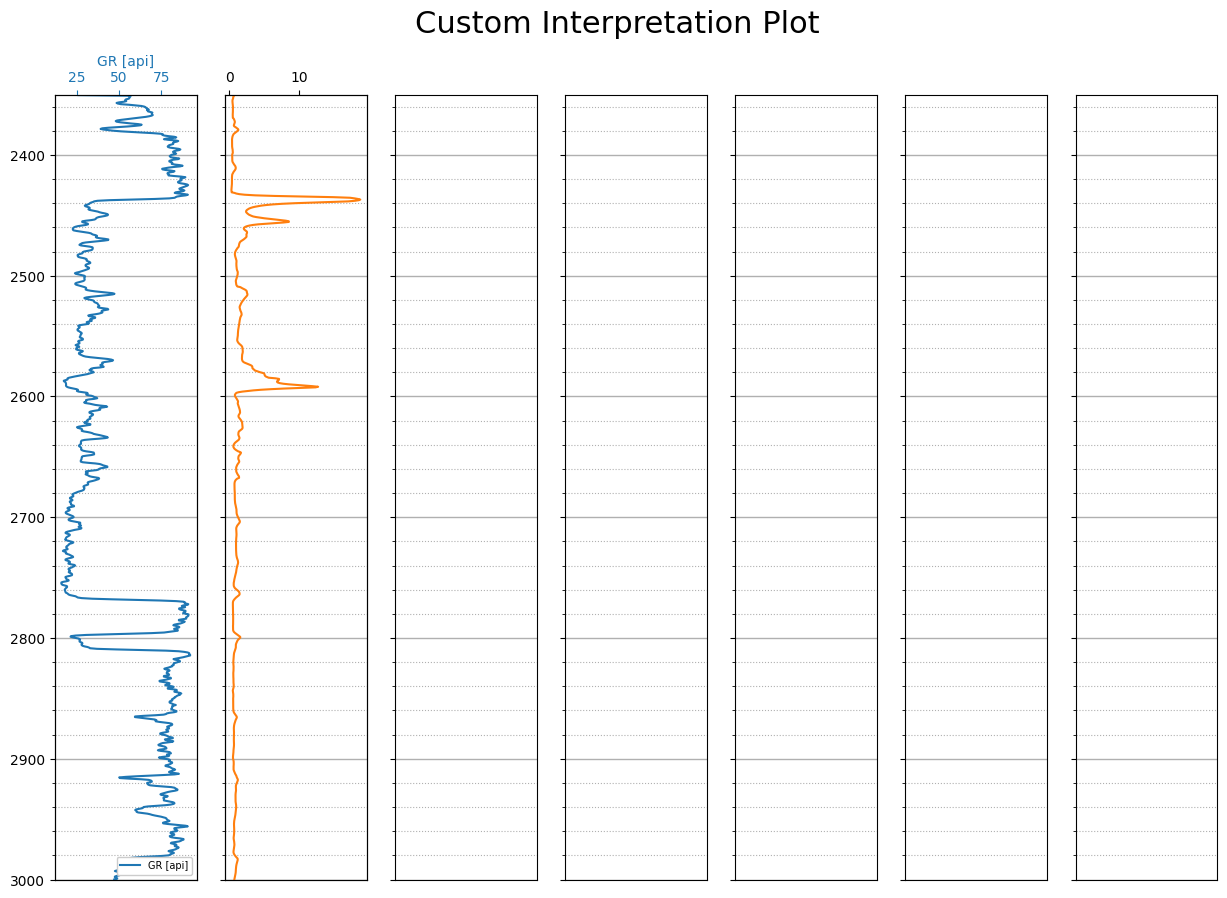

In [46]:
from src.data_vis.comboPlot import custom_plot

custom_data = ["GR", "DR", "MR", "RHOB", "NPHI", "VSH", "RW"]
units = ["api", "m.ohm", "ohm.m", "g/cc", "%", "v/v", "ohm"]
res_range = [0.1, 1]
res_scale = "linear"
custom_plot(data, depth_start, depth_end, custom_data, units, res_range, res_scale)

# **4. Data Selection and Calculations**

In [ ]:
# Create a copy of the data for selected well
calculation_data = data[data["WELL"] == well_name].copy()

calculation_data.describe()

## **5. CLAY VOLUME CALCULATION**

## **Define Logs Variable for Calculations**

#### **Define the Clean and Clay Paramater**
- Minimum (clean) and maximum (clay) values of GR for both
- Minimum (clean) and maximum (clay) values of SP for both
- Minimum (clean) and maximum (clay) values of RT for both
#
To start with, simply guess any numbers. Then, refer to the crossplot results in nphi vs rhob plot

In [ ]:
columns_list = ["GR", "DR", "NPHI"]
the_units = ["unit" for i in range(len(columns_list))]

histplot(calculation_data, columns_list, the_units, depth_start=2350, depth_end=3000)

In [ ]:
# Clean point 1 (typical for a dense, clean rock like limestone)
neut_clean1 = 0.1  # NPHI of 0.1 (low porosity)
den_clean1 = 2.45  # RHOB of 2.45 g/cc (dense rock)

# Clean point 2 (moderate porosity, consolidated formation)
neut_clean2 = 0.25  # NPHI of 0.25 (moderate porosity)
den_clean2 = 2.0  # RHOB of 2.0 g/cc (consolidated, possibly sandstone)

# Clay point (high density, low porosity)
neut_clay = 0.05  # NPHI of 0.05 (low porosity, more clay)
den_clay = 2.65  # RHOB of 2.65 g/cc (typical for clay-rich formations)

# sand and shale baseline
gr_clean, gr_clay = 40, 110
rt_clean, rt_clay = 1.8, 1.6

In [ ]:
from src.data_vis.helperFunc import nd_crossplot

filter_data = calculation_data[
    (calculation_data.DEPT >= depth_start) & (calculation_data.DEPT <= depth_end)
].copy()
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[:])
nd_crossplot(
    filter_data,
    ax,
    fontsize=10,
    clean_point1=[neut_clean1, den_clean1],
    clean_point2=[neut_clean2, den_clean2],
    clay_point=[neut_clay, den_clay],
    nphi_axis=[0, 1],
    rhob_axis=[2, 2.75],
)

In [ ]:
from src.data_calc.vclCalc import vclrt, vclgr, vclnd, vclsp

calculation_data["VCLGR"] = vclgr(data.GR, gr_clean, gr_clay, correction="older")
calculation_data["VCLRT"] = vclrt(data.DR, rt_clean, rt_clay)
calculation_data["VCLND"] = vclnd(
    data.NPHI,
    data.RHOB,
    neut_clean1,
    den_clean1,
    neut_clean2,
    den_clean2,
    neut_clay,
    den_clay,
)

In [ ]:
from src.data_vis.vclPlot import vcl_plot

vcl_plot(
    calculation_data,
    depth_start=depth_start,
    depth_end=depth_end,
    traject1={
        "data": ["GR", "DR"],
        "intervals": [(0, 100), (0.1, 10)],
        "scales": ["linear", "log"],
        "labels": ["GR[api]", "DR[ohm.m]"],
        "colors": ["green", "purple"],
    },
    traject2={
        "data": ["GR", "DR"],
        "scales": ["linear", "linear"],
        "labels": ["GR[api]", "DR[ohm.m]"],
        "colors": ["green", "purple"],
    },
    traject3={
        "data": ["VCLRT", "VCLND", "VCLGR"],
        "labels": ["VCLRT[v.v]", "VCLND[v.v]", "VCLGR[v.v]"],
        "colors": ["green", "red", "blue"],
    },
    clean_point1=[neut_clean1, den_clean1],
    clean_point2=[neut_clean2, den_clean2],
    clay_point=[neut_clay, den_clay],
    rhob_axis=[2, 2.75],
    nphi_axis=[0, 1],
)

In [ ]:
custom_data = ["VCLGR", "VCLND", "VCLRT"]
units = ["v.v" for i in range(len(custom_data))]
custom_plot(calculation_data, depth_start, depth_end, custom_data, units)

In [ ]:
calculation_data["VCL"] = calculation_data["VCLRT"]

## **6. POROSITY CALCULATION**
There are three types of logs that can be used to estimate porosity: sonic, density, and neutron logs. Porosity can be determined using either individual or paired combinations of these logs. The possible combinations include neutron-density, neutron-sonic, and sonic-density.<br>
**Basic porosity formulas are:**
- Sonic:
    - Wyllie (Time Average)
    - Raymer-Hunt-Gardner
- Density
- Neutronic<br>

## **Define the Parameter for Porosity Calculations**

In [ ]:
from src.data_calc.poroCalc import phis_shale

# Matrix, fluid and appropiate shales values must be declared in the next variables:
dt_ma, dt_fl, dt_sh, cp, alpha = 55.5, 188.0, 90.0, 1, 5 / 8
den_ma = 2.24
den_fl = 0.1
den_sh = den_clay

phis_sh = phis_shale(dt_sh, dt_ma, dt_fl)
phid_sh = phis_shale(den_sh, den_ma, den_fl)
phin_sh = 45

In [ ]:
from src.data_calc.poroCalc import (
    phis_w,
    phis_w_sh_corr,
    phis_rhg,
    phis_rhg_sh_corr,
    phid,
    phid_sh_corr,
    phi_simandoux,
    phin_sh_corr,
    phixnd,
)

# # 1. Poro calc with DT
calculation_data["PHISw"] = phis_w(data.DT, dt_ma, dt_fl, cp)
calculation_data["PHISwshc"] = phis_w_sh_corr(
    data.DT, dt_ma, dt_fl, cp, dt_sh, calculation_data.VCL
).clip(0, 1)

calculation_data["PHISrhg"] = phis_rhg(data.DT, dt_ma, alpha)
calculation_data["PHISrhgshc"] = phis_rhg_sh_corr(
    data.DT, dt_ma, dt_sh, calculation_data.VCL, alpha, dt_fl
).clip(0, 1)

# # 2. Poro calc with RHOB
calculation_data["PHID"] = phid(data.RHOB, den_ma, den_fl, new=True)
calculation_data["PHIDshc"] = phid_sh_corr(
    data.RHOB, den_ma, den_fl, den_sh, calculation_data.VCL
).clip(0, 1)

# # 3. Poro calc for Simandoux using VSH param
calculation_data["PHI_SIMANDOUX"] = phi_simandoux(data.VSH, calculation_data.PHID).clip(
    0, 1
)

# # 4. Poro calc with NPHIN (Dual-method)
calculation_data["PHIN"] = (data.NPHI / 100).clip(0, 1)
calculation_data["PHINshc"] = phin_sh_corr(
    data.NPHI, phin_sh, calculation_data.VCL
).clip(0, 1)

calculation_data["PHIxND"] = phixnd(
    calculation_data.PHINshc, calculation_data.PHIDshc
).clip(0, 1)

In [ ]:
# Example usage:
custom_data = ["PHIN", "PHID", "PHIxND", "PHI_SIMANDOUX"]
units = ["v.v" for i in range(len(custom_data))]
custom_plot(
    calculation_data,
    depth_start,
    depth_end,
    custom_data,
    units,
)

In [ ]:
calculation_data["PHIE"] = calculation_data["PHID"]

## **7. WATER SATURATION CALCULATION**
Before calculating the water saturation will need a value for the Rw (Resistivity of water)<br>
**Resistivity of water:**
It can be determined from:
- Ater catalogs <br>
- DST test water analysis <br>
- Rw from SP (needs information about Rmud and ... ) <br>
- Rwa Method (Rw from a 100% water zone) <br>

### **7.1. Archie Water Sturation Equation**
Suppose we lack any prior knowledge of Rwater. In such cases, following the best approach involves utilizing a PICKETT graph. This graph takes on a logarithmic form derived from Archie's equation:
$Sw^{n} = \frac{a \times R_w}{R_t \times \phi^m}$

## **Define the Parameters**
Firstly, it's important to establish the values for the variables: a, m, and n. To initiate this process, you might consider beginning with the values (a=1, m=2, n=2), which tend to yield favorable results across various rock types. In cases where the rock matrix contains a mixture of shale, it might be advisable to reduce the value of m to 1.8.
- a, turtuosity factor
- m, cementation factor
- n, saturation exponent
- rwa, water resistivity
- vcl_limit, volume of clay upper limit for selction of data for graph

In [ ]:
a = 0.9
m = 1
n = 1.8

### **7.1.2. Choose the Water Resistivity**

In [ ]:
from src.data_vis.interpretPlot import pickett_plot

rwa_input = 0.12

pickett_plot(
    calculation_data,
    depth_start=depth_start,
    depth_end=depth_end,
    vcl_limit=0.5,
    a=a,
    rwa=rwa_input,
    m=m,
    n=n,
    z="VCL",
)

In [ ]:
Rw = 0.12  # best Water resistivity based on picket plot

The outcomes obtained from the Pickett plot indicate the presence of distinct intervals within two zones, warranting separate interpretation and analysis. To initiate the process, we will select an appropriate value for Rwa and utilize the Archie equation to compute the Sw curve.
#
Next, proceed to select the water resistivity, denoted as rwa. We will create a Pickett chart by plotting Resistivity against Porosity. To curate the data for this plot, focus exclusively on the reservoir formations while excluding the shaly intervals. This can be accomplished by adjusting the vcl_limit variable, which represents the volume of clay.

#### **8.2.1. Define the Thermal Gradient for Waxman-Smits Water Saturation Calculation**

In [ ]:
# Geothermal Gradient
mid_perf = 13950  # TVD
BHT_mid_perf = 192  # Fahrenheit
T_surf = 60  # Fahrenheit
T_gradient = (BHT_mid_perf - T_surf) / (mid_perf)  # Fahrenheit/ft

# Create new column 'CEC' and 'T' for SWwaxman Calc
calculation_data["CEC"] = (
    -47.619 * calculation_data["VCL"] ** 2.0 + 61.429 * calculation_data["VCL"]
)
calculation_data["T"] = T_surf + T_gradient * data["DEPT"]

#### **8.1.3. Calculation of the Water Saturation**
and call it in order to have the result of saturation Swa. Clip the results between (0,1).

In [ ]:
len(calculation_data.RW)

In [ ]:
from src.data_calc.swCalc import (
    sw_indonesia,
    sw_archie,
    sw_simandoux,
    sw_waxman,
    sw_waxman_vectorized,
)

calculation_data["SWarchie"] = sw_archie(
    Rw, data.DR, calculation_data.PHIE, a, m, n
).clip(0, 1)

calculation_data["SWsimandoux"] = sw_simandoux(
    Rw, data.DR, data.VSH, calculation_data.PHIE, a, m, n, Rsh=100
).clip(0, 1)

calculation_data["SWwaxman"] = calculation_data.apply(
    lambda col: sw_waxman(
        Rw,
        col["CEC"],
        a,
        m,
        n,
        col["T"],
        col.DR,
        col.PHIE,
    ),
    axis=1,
).clip(0, 1)

calculation_data["SWindonesia"] = sw_indonesia(
    Rw, data.DR, calculation_data.PHIE, a, m, n, calculation_data.VCL, rsh=100
).clip(0, 1)

## **Bulk volume water Calc**

In [ ]:
calculation_data["BVW"] = calculation_data["SWarchie"] * calculation_data["PHIE"]
calculation_data["matrix"] = 1 - calculation_data["VCL"] - calculation_data["PHIE"]

## **Choose best SW**

In [ ]:
custom_sw = ["SWsimandoux", "SWarchie", "SWindonesia", "SWwaxman"]
units = ["v.v" for i in range(len(custom_data))]
custom_plot(calculation_data, depth_start, depth_end, custom_sw, units)

In [ ]:
from src.data_calc.permCalc import perm_timur

calculation_data["PERMtimur"] = calculation_data.apply(
    lambda row: perm_timur(row["PHIE"], row["SWarchie"]), axis=1
)

## **Interpretation Plot**

In [ ]:
from src.data_vis.interpretPlot import interpretation_plot

NPHI_max = 100
NPHI_min = 0
interpretation_plot(
    calculation_data,
    depth_start=depth_start,
    depth_end=depth_end,
    traject1={
        "data": ["GR"],
        "intervals": [(0, 100)],
        "scales": ["linear"],
        "labels": ["GR [API]"],
        "positions": [0],
        "colors": ["green"],
    },
    traject2={
        "data": ["DR", "MR", "SR"],
        "intervals": [(0.1, 10), (0.1, 10), (0.1, 10)],
        "scales": ["log", "log", "log"],
        "labels": ["DR[omh.m]", "MR[ohm.m]", "SR[ohm.m]"],
        "positions": [80, 40, 0],
        "colors": ["black", "purple", "red"],
    },
    traject3={
        "data": ["RHOB", "NPHI"],
        "intervals": [(0, 2.75), (1.05, -0.15)],
        "scales": ["linear", "linear"],
        "labels": ["RHOB[g/cc]", "NPHI[unit]"],
        "positions": [40, 0],
        "colors": ["red", "green"],
    },
    traject4={
        "data": ["SWarchie", "SWsimandoux"],
        "intervals": [(0, 1), (0, 1)],
        "scales": ["linear", "linear"],
        "labels": ["Archie[v.v]", "Simandoux[v.v]"],
        "positions": [0, 40],
        "colors": ["black", "magenta"],
    },
    traject5={
        "data": ["PERMtimur"],
        "intervals": [(0, 1)],
        "scales": ["linear"],
        "labels": ["perm[unit]"],
        "positions": [0],
        "colors": ["violet"],
    },
    traject6={
        "data": ["BVW", "PHIE"],
        "intervals": [(0, 0.1), (0, 0.1)],
        "scales": ["linear", "linear"],
        "labels": ["BVW[unit]", "PHIE[unit]"],
        "positions": [40, 0],
        "colors": ["red", "black"],
    },
    traject7={
        "data": ["PHIE", "VCL"],
        "intervals": [(1, 0), (1, 0)],
        "scales": ["linear", "linear"],
        "labels": ["PHIE[unit]", "VCL"],
        "positions": [0, 40],
        "colors": ["green", "red"],
    },
    fill=True,
)

## **Save the all of the output to xlsx files**

In [ ]:
# Specify the file path where you want to save the Excel file
file_path = "../results/output1.xlsx"

# Export the DataFrame to an Excel file
calculation_data.to_excel(
    file_path, index=False
)  # Set index=False to exclude the index column

print(f"DataFrame has been exported to {file_path}")

## **Other crossplot**

In [ ]:
from src.data_vis.distPlot import crossplot

crossplot(calculation_data, "NPHI", "RHOB", "GR", "frac", "g/cc", "API")